# Predicting Movie Release Year and Genre
### By: Matthew Fernandez & Andrew Cline

In this notebook we will dive into a dataset regarding movies made from the early 1900s to 2017, each movie has features like plot synposis, Release year, Genre, cast, title, Orgin/Ethnicity, Director, and Wikipedia Page. We are intrested in predicting the top five most occuring genre labels and the release year of a movie given all other features. We will build one RNN model to tackle both of these tasks accurately. Lets begin with some needed imports.

In [ ]:
import string
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns 
import matplotlib.pyplot as plt
import keras.layers
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import resample
from scipy import stats

## Read in Data
This dataset was taken from Kaggle, https://www.kaggle.com/jrobischon/wikipedia-movie-plots/version/1 on November 18th, 2021. There are roughly 33K instances with 8 total features, six of which will be used to predict the title and genre.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
df = pd.read_csv("/content/gdrive/MyDrive/Machine Learning Colab Notebooks/data/wiki_movie_plots_deduped.csv")

Mounted at /content/gdrive/


## Initial Data Exploration 
<br> Lets take a look at the first 20 rows of our dataset.

In [ ]:
df.head(20)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


As we can see, the dataset is in ascending order by release year, and there are a handful of nan values within the cast feature. There is also a handful of Unknown genre types, we intent to remove these movies but before we do, we need to make sure that we are not dropping too many movies. Most of the data in this data set is text, but the type of text varies in each feature. For example Plot is a long string of text that describes the plot of the movie, where as Origin/Ethnicity is just label corresponding the country of origin. We will later drop the Wiki Page column since this will be of no help for our task.<br><br>Lets now take a look at a summary of the dataframe. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


Looks like there are a few na values in Cast, around 1422 values to be exact, all other columns are not na values.<br><br> What is the range of values in release year?

In [ ]:
df.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


Looks like the midpoint of the release year is 1981, the largest value is 2017 and the minimum value is in 1901.<br><br>Let us now take a look at the distribution of the release year.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


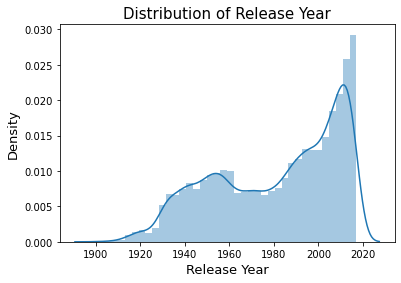

In [ ]:
sns.distplot(df['Release Year'])
plt.title('Distribution of Release Year', fontsize=15)
plt.xlabel('Release Year', fontsize=13)
plt.ylabel('Density', fontsize=13);

From the above distribution plot, we can see that a majority of our data consists of movies that took place after the 1980s.  There is a maximum in the plot that shows a majority of release year ranges from 2010 to 2017. This is interesting, if we are to blindly guess a year, the best guess would be from 2010-2017. If we are to use the release year as is, our model would make two predictions, release year would be a regression task, and predicting the genre would be a classification task. This is a model we can assume will either do well on one task and bad on the other or altogether perform poorly.  We will predict the decade rather than the release year to avoid said problems. 

# Data Cleaning

Let us now visualize the top five genre occurrences. We will also create the new feature 'decade' from which the recurrent neural network will predict.

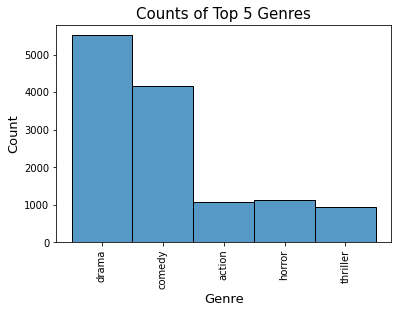

In [ ]:
# drop na values that occur in Cast
df.dropna(inplace=True)
df2 = df['Genre'].value_counts()[df['Genre'].value_counts() > 150]
genres = df2.keys()
df3 = df[df["Genre"].isin(genres)] # dataframe with the genres we have counts > 150

df_genre = df3['Genre'].value_counts()[:6].keys()
df3 = df3[df3['Genre'].isin(df_genre)]
df4 = df3[df3['Genre'] != 'unknown']
df5 = df4.dropna(axis=0)
df5['decade'] = pd.cut(df5['Release Year'], bins=[1900, 1909,1919,1929,1939,1949,1959,1969,1979,1989,1999,2009,2029], labels=['1900s','10s','20s', '30s','40s',
                                                                                                        '50s','60s','70s',
                                                                                                        '80s', '90s', '2000s',
                                                                                                        '2010s'])
df5 = df5[df5['decade'].isin(['1900s', '10s', '20s']) == False]
sns.histplot(df5['Genre'])
plt.title('Counts of Top 5 Genres',fontsize=15)
plt.ylabel('Count',fontsize=13)
plt.xlabel('Genre',fontsize=13)
plt.xticks(rotation=90);

We can see here that drama is the most occurring genre followed by comedy. horror and action are very similar in counts and lastly thriller.

## Pre-processing
Let us now prepare the data for Machine Learning. We will apply word embedding to our features that will be passed into our model. We have to vectorize each feature independently. The Text Vectorization layer code was obtained from the Keras documentation on text classification.

In [ ]:
# remove feature Wiki Page, not useful for this application
X = df5[['Plot', 'Origin/Ethnicity', 'Director', 'Cast']].values
le = LabelEncoder()
y1 = df5['Genre'].values
y2 = df5['decade'].values
le.fit(y1)
y1 = le.transform(y1)
le2 = LabelEncoder()
le2.fit(y2)
y2 = le2.transform(y2)
y = np.vstack((y1,y2)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

genre_labels = df5['Genre'].unique() 
year_labels = df5['decade'].unique()

def standardize(input_data):
  lower = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lower, f"[{re.escape(string.punctuation)}]","")

plot_vectorized_layer = layers.TextVectorization(
    standardize=standardize,
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=1000
)
plot_vectorized_layer.adapt(X_train[0:,0])
origin_vectorized_layer = layers.TextVectorization(
    standardize=standardize,
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=1000
)
origin_vectorized_layer.adapt(X_train[0:,1])
director_vectorized_layer = layers.TextVectorization(
    standardize=standardize,
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=1000
)
director_vectorized_layer.adapt(X_train[0:,2])
cast_vectorized_layer = layers.TextVectorization(
    standardize=standardize,
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=1000
)
cast_vectorized_layer.adapt(X_train[0:,3])

Above we also implemented the y values to be encoded from 0 to n.

## Machine Learning
<br>
Let us now build a basic baseline by always predicting the most common decade along with genre. 
<br> 

### Baseline Model

In [ ]:
y_baseline_genre = stats.mode(y_test[0:,0], axis=None).mode[0]
genre_test_accuracy = sum(y_baseline_genre == y_test[0:,0]) / len(y_test[0:,0])
print('test accuracy genre: {:0.2f}'.format(genre_test_accuracy))
y_baseline_year = stats.mode(y_test[0:,1], axis=None).mode[0]
year_test_accuracy = sum(y_baseline_year == y_test[0:,1]) / len(y_test[0:,1])
print('test accuracy genre: {:0.2f}'.format(year_test_accuracy))

test accuracy genre: 0.43
test accuracy genre: 0.17


For genre, since the most common value 'Drama' represents a high proportion of the data the baseline is high. For year, that low value is to be expected since there is a relatively good spread of data.

# Actual Model

Building the RNN Model

In [ ]:
plot_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='plot_input')
cast_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='cast_input')
director_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='director_input')
origin_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='origin_input')
plot_out = plot_vectorized_layer(plot_input)
plot_out = layers.Embedding(10000, 32)(plot_out)
plot_out = layers.BatchNormalization()(plot_out)
plot_out = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(plot_out)
cast_out = cast_vectorized_layer(cast_input)
cast_out = layers.Embedding(10000, 32)(cast_out)
cast_out = layers.BatchNormalization()(cast_out)
cast_out = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(cast_out)
director_out = director_vectorized_layer(director_input)
director_out = layers.Embedding(10000, 32)(director_out)
director_out = layers.BatchNormalization()(director_out)
director_out = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(director_out)
origin_out = origin_vectorized_layer(origin_input)
origin_out = layers.Embedding(10000, 32)(origin_out)
origin_out = layers.BatchNormalization()(origin_out)
origin_out = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(origin_out)
concat = layers.concatenate([plot_out, cast_out, director_out, origin_out])
# x = layers.GRU(64)(concat)
x = layers.Flatten()(concat)
year_output = layers.Dense(len(year_labels), activation='softmax', name = 'year_output')(x)
genre_output = layers.Dense(len(genre_labels), activation='softmax', name='genre_output')(x)
model = keras.Model(inputs=[plot_input, cast_input, director_input, origin_input], outputs=[year_output, genre_output])

So for this model there is 4 different input layers to account for 4 different embedding spaces for each input. Each input gets its own Batch Normalization layer and birdirectional LSTM layer. After all the models tried, giving each input its own LSTM layers instead of after the concatenation has proved to be the best method.<br><br>Compiling the RNN model

In [ ]:
callback_year  = EarlyStopping(patience=4, monitor='val_year_output_loss')
callback_genre = EarlyStopping(patience=4, monitor='val_genre_output_loss')# stop after overfitting on the 4th epoch

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# indexing the X_train list of np arrays
input_train = {'plot_input' : X_train[0:,0],
    'origin_input' : X_train[0:,1],
    'director_input' : X_train[0:,2],
    'cast_input' : X_train[0:,3]}
input_test = {'plot_input' : X_test[0:,0],
    'origin_input' : X_test[0:,1],
    'director_input' : X_test[0:,2],
    'cast_input' : X_test[0:,3]}

history = model.fit(input_train, 
                    {'genre_output': y_train[0:,0], 'year_output' : y_train[0:,1]},
                    epochs=100, batch_size=64,
                    validation_data=(input_test, {'genre_output' : y_test[0:,0], 'year_output' : y_test[0:,1]}),
                   callbacks=[callback_year, callback_genre])

Epoch 1/100
141/141 [==============================] - 202s 1s/step - loss: 3.1344 - year_output_loss: 1.8801 - genre_output_loss: 1.2543 - year_output_acc: 0.3198 - genre_output_acc: 0.5062 - val_loss: 4.5071 - val_year_output_loss: 2.5004 - val_genre_output_loss: 2.0067 - val_year_output_acc: 0.0842 - val_genre_output_acc: 0.0798
Epoch 2/100
141/141 [==============================] - 152s 1s/step - loss: 0.9134 - year_output_loss: 0.5379 - genre_output_loss: 0.3755 - year_output_acc: 0.8232 - genre_output_acc: 0.8716 - val_loss: 3.2695 - val_year_output_loss: 1.9597 - val_genre_output_loss: 1.3099 - val_year_output_acc: 0.2132 - val_genre_output_acc: 0.5025
Epoch 3/100
141/141 [==============================] - 164s 1s/step - loss: 0.1963 - year_output_loss: 0.1142 - genre_output_loss: 0.0821 - year_output_acc: 0.9744 - genre_output_acc: 0.9815 - val_loss: 2.4387 - val_year_output_loss: 1.4554 - val_genre_output_loss: 0.9833 - val_year_output_acc: 0.4172 - val_genre_output_acc: 0.621

In order to prevent over fitting, Early Stopping is used on both the validation loss of year and genre. Also since each input goes to a different layer a dictionary for input had to be created so that each input can explicity be associated with its layers.<br><br>Lets now plot the validation loss given from predicting both genre and decade 

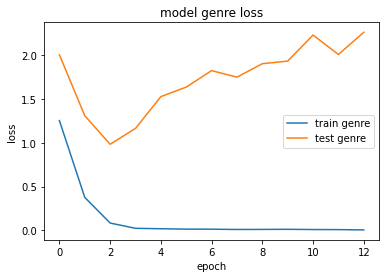

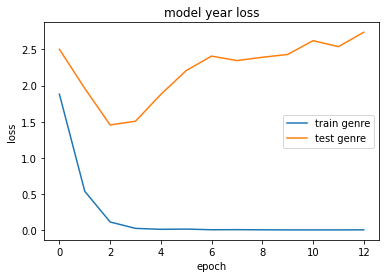

In [ ]:
def plot_metric(history, output, metric='loss'):
    """ Plot training and test values for a metric. """
    val_metric = 'val_{}_output_loss'.format(output)
    train_metric = '{}_output_loss'.format(output)
    plt.plot(history.history[train_metric])
    plt.plot(history.history[val_metric])
    plt.title('model {} '.format(output) + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train genre', 'test genre', 'train year', 'test year'])
    plt.show();

plot_metric(history, 'genre')
plot_metric(history, 'year')

We can see that the Model overfits after the 3rd epoch for both prediction tasks.<br><br> What is the accuracy found with our model?

In [ ]:
y_predict_genre = model.predict(input_test)[1].argmax(axis=1)
genre_test_accuracy = sum(y_predict_genre == y_test[0:,0]) / len(y_test[0:,0])
print('test accuracy genre: {:0.2f}'.format(genre_test_accuracy))
y_predict_year = model.predict(input_test)[0].argmax(axis=1)
year_test_accuracy = sum(y_predict_year == y_test[0:,1]) / len(y_test[0:,1])
print('test accuracy year: {:0.2f}'.format(year_test_accuracy))

test accuracy genre: 0.61
test accuracy year: 0.47


# Conclusion

The baseline found when predicting the most common decade and genre gave us an accuracy of 43% and 17% respectively. The optimal neural network that gave us the best results for the task of predicting the top 5 most genres of the given movie, along with the decade resulted in 4 different inputs each with its own word embedding. The output of the genre needed to be encoded from 0 to n. The architecture we found best was an embedding layer followed by a batch normalization layer, and finally a bidirectional LSTM layer. Also, we implemented early stopping and were able to avoid the model from overfitting dramatically. We obtained a very well-performing model that outperformed the baseline, for the decade we got 30% better accuracy and for the genre, the task performed 18% greater. It must be noted that when running the notebook on an Nvidia RTX 3080 GPU the accuracy achieved was better than when run on the NVIDIA Tesla K80 GPU that Colab provides. To improve this model in the future there would need to be more movie data and probably more concise labels for the genre on some movies. For example, there was a lot of data lost when removing all genres with a low amount of movies within.